In [1]:
import h5py
import numpy as np
import pandas as pd
import os
from math import *

import gc
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns

import scipy as sci
from scipy import signal
from scipy.signal import blackman

import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#import pyeeg
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
#from lightgbm import LGBMClassifier

#import mne

In [2]:
os.chdir('C:/Users/Thibault/Desktop/Projet Machine Learning')

### load data

In [3]:
def loading():
    f_train = h5py.File('Data/train.h5','r')
    train = pd.read_csv('Data/train_y.csv',delimiter =';')
    #f_test = h5py.File('test.h5','r') 
    return f_train, train
f_train, Y = loading()
key = list(f_train.keys())

def split(dataset):
    #Accelerometer
    Acc = []
    Acc.append(dataset['accelerometer_x'].value)
    Acc.append(dataset['accelerometer_y'].value)
    Acc.append(dataset['accelerometer_z'].value)
    #Heart beat
    Hea = []
    Hea.append(dataset['pulse_oximeter_infrared'].value)
    #EEGs
    Eeg = []
    for i in range(1,8):
        Eeg.append(dataset['eeg_'+str(i)].value)
    return Acc, Hea, Eeg

Acc, Hea, Eeg = split(f_train)
Eeg = np.array(Eeg)
Eeg = Eeg.reshape(38289,7,1500)

Y = Y.values.reshape((-1,))
Y = [int(x.split(',')[1]) for x in Y]

### Features function

In [4]:
def vc(eeg):
    vcount = np.zeros(41)
    for elt in eeg:
        if elt<-200:
            vcount[0]+=1
        elif elt>=200:
            vcount[40]+=1
        else:
            vcount[floor(elt/10)+20]+=1
    return vcount

def ent(data):
    vcount = vc(data)
    
    p_data= vcount/len(data) # calculates the probabilities
    entropy=sci.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

            
def maximum_minimum_distance(data, f_ech=50, Lambda=100):
    distance = 0
    nbre_fenetre = len(data) // Lambda
    for i in range(nbre_fenetre):
        indice_max = np.argmax(data[i * 100:(i + 1) * 100 - 1]) + i * 100
        indice_min = np.argmin(data[i * 100:(i + 1) * 100 - 1]) + i * 100
        distance += np.sqrt(
            (data[indice_max] - data[indice_min]) ** 2 + ((indice_max - indice_min) / f_ech) ** 2)
    return distance

### Extract numpy

In [5]:
def extract_features_np_perf(n):
    data = Eeg[:n,:,:]
    debut = time.time()
    m = data.mean(axis=2).reshape(n,7,1)
    std = data.std(axis=2).reshape(n,7,1)
    entropy = np.zeros((n,7,1))
    dist = np.zeros((n,7,1))
    for i in range(n):
        for j in range(7):
            entropy[i,j,0]=ent(data[i,j,:])
            dist[i,j,0]=maximum_minimum_distance(data[i,j,:])
    np.concatenate([m,std,entropy,dist],axis=2).reshape(n,-1)
    return time.time()-debut

### Extract Pyspark

In [6]:
import findspark

findspark.init()

from pyspark.sql.types import *
from pyspark.sql.functions import udf

schema = StructType([StructField("eeg1", ArrayType(FloatType())),\
                     StructField("eeg2", ArrayType(FloatType())),\
                     StructField("eeg3", ArrayType(FloatType())),\
                     StructField("eeg4", ArrayType(FloatType())),\
                     StructField("eeg5", ArrayType(FloatType())),\
                     StructField("eeg6", ArrayType(FloatType())),\
                     StructField("eeg7", ArrayType(FloatType()))])

get_mean_udf = udf(lambda x : np.mean(np.array(x)).tolist(),returnType=FloatType())
get_std_udf = udf(lambda x: np.std(np.array(x)).tolist(), returnType=FloatType())
get_entropy_udf= udf(lambda x: ent(x).tolist(), returnType=FloatType())
get_minmax_udf = udf(lambda x: maximum_minimum_distance(x).tolist(), returnType = FloatType())

In [7]:
channels = ['eeg1','eeg2','eeg3','eeg4','eeg5','eeg6','eeg7']
features = ['mean','std','entropy','minmax']
all_features = []

for feature in features:
    for channel in channels:
        all_features.append(feature+'_'+channel)
feature_func = {'mean': get_mean_udf, 'std': get_std_udf,'entropy': get_entropy_udf,'minmax':get_minmax_udf}


def extract_features_pyspark_perf(n):
    L = [[Eeg[i,j,:].tolist() for j in range(7)] for i in range(n)]
    sdf = sqlCtx.createDataFrame(L,schema=schema)
    debut = time.time()
    for feature in features:
        udf_func = feature_func[feature]
        for channel in channels:
            sdf = sdf.withColumn(feature+'_'+channel, udf_func(channel))
    rdd = sdf.select(all_features).rdd
    rdd.collect()
    return time.time()-debut     

### Comparaison

In [8]:
n_range = np.linspace(100,4000,num=8).astype(int)

In [9]:
import pyspark
from pyspark.sql import SQLContext
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                   ('spark.executor.cores', '8'), 
                                   ('spark.cores.max', '8'), 
                                   ('spark.driver.memory','8g')])
sc=pyspark.SparkContext(conf = conf)
sqlCtx = SQLContext(sc)

res_spark = []
res_np = []
print('Avec spark:')
for n in n_range:
    res_spark.append(extract_features_pyspark_perf(n))
    print('\t'+str(n)+' ok')

print('Avec numpy:')
for n in n_range:
    res_np.append(extract_features_np_perf(n))
    print('\t'+str(n)+' done')


Avec spark:
	100 ok
	657 ok
	1214 ok
	1771 ok
	2328 ok
	2885 ok
	3442 ok
	4000 ok
Avec numpy:
	100 done
	657 done
	1214 done
	1771 done
	2328 done
	2885 done
	3442 done
	4000 done


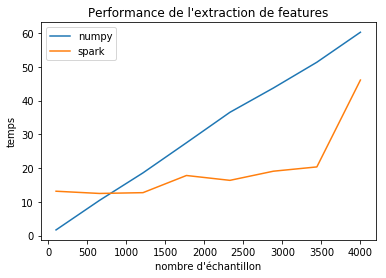

In [11]:
plt.plot(n_range,res_np,label='numpy')
plt.plot(n_range,res_spark,label='spark')
plt.xlabel('nombre d\'échantillon')
plt.ylabel('temps')
plt.legend()
plt.title('Performance de l\'extraction de features')
plt.show()

## Classification

In [27]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

def extract_features_pyspark(data):
    L = [[data[i,j,:].tolist() for j in range(7)] for i in range(data.shape[0])]
    sdf = sqlCtx.createDataFrame(L,schema=schema)
    debut = time.time()
    for feature in features:
        udf_func = feature_func[feature]
        for channel in channels:
            sdf = sdf.withColumn(feature+'_'+channel, udf_func(channel))
    rdd = sdf.select(all_features).rdd
    return rdd.collect()

In [9]:
X_train, Y_train = Eeg[:5000,:,:], Y[:5000]
X_test, Y_test = Eeg[5000:7000,:,:], Y[5000:7000]

Extraction avec pyspark

In [10]:
import pyspark
from pyspark.sql import SQLContext
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                   ('spark.executor.cores', '8'), 
                                   ('spark.cores.max', '8'), 
                                   ('spark.driver.memory','8g')])
sc=pyspark.SparkContext(conf = conf)
sqlCtx = SQLContext(sc)

In [ ]:
X_train_features = extract_features_pyspark(X_train)
X_test_features = extract_features_pyspark(X_test)

Transformation en numpy array

In [19]:
X_train_features = np.concatenate([np.array(X_train_features[i]).reshape((1,28))\
                                   for i in range(len(X_train_features))],axis=0)
X_test_features = np.concatenate([np.array(X_test_features[i]).reshape((1,28))\
                                   for i in range(len(X_test_features))],axis=0)

In [64]:
pipeline = Pipeline([('scale',StandardScaler()),('pca',PCA(n_components=8)),('svm',SVC(C=500, kernel='rbf'\
                                                                                       ,gamma=10,class_weight='balanced'))])
pipeline.fit(X_train_features,Y_train)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svm', SVC(C=500, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [66]:
Y_pred = pipeline.predict(X_test_features)
print(f1_score(Y_test,Y_pred,average='micro'))

0.278
